# Photometry of an open cluster

This juypter notebook consist of the scripts necessary to calculate the color-magnitude diagram of an open cluster. The individual scripts here assume perfectly calibrated and reduced (hence bias-, flat- and dark-frame corrected) observations. In case the calibrations were not done completely, some scripts (especially the star finding) may not work properly.

### As a first step, the relevant python packages have to be imported.
It is assumed, that these are already installed for the python environment that will be used for the analysis. If not sure, check the necessary dependencies with << environment list >>

In [1]:
%pylab inline
from astropy.io import fits
import pandas as pd

from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks
from photutils import CircularAperture
from photutils.aperture import ApertureStats
from photutils import background
from photutils import aperture_photometry
from astropy.stats import SigmaClip

from astropy.nddata import Cutout2D

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Load the file(s) that you will be working on.

TODO: How the RGB files should be separated? Shall we do everything at once?

##### This stuff should still be tailored a bit in accordance with Alejandra's reduction pipeline

In [4]:
observation_files = ['./M36-001_B.fit', './M36-001_G.fit', './M36-001_R.fit']

dark = fits.open('./DARK_5s.fit')

observation = fits.open('./M36-001_B.fit')

d_arr = dark[0].data.astype(float)
o_arr = observation[0].data.astype(float)

corr_arr = o_arr - d_arr
fail_cnd = corr_arr < -1000
corr_arr[fail_cnd] = 0

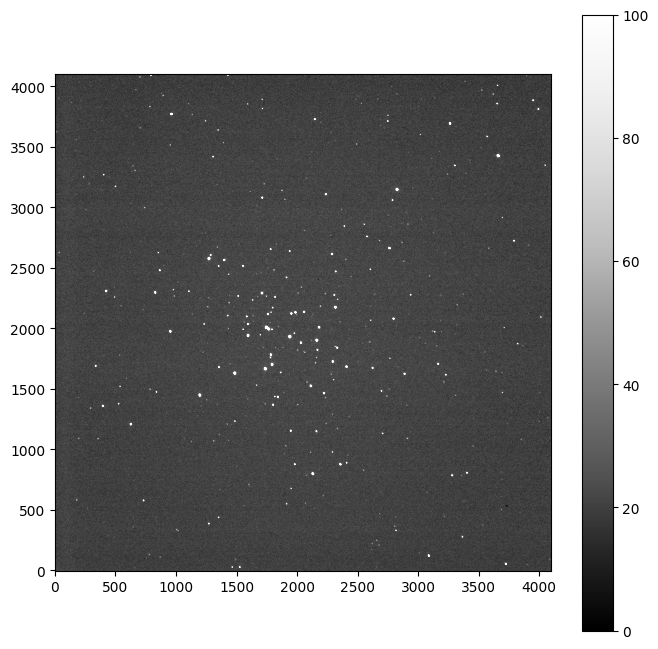

In [5]:
plt.figure(figsize = (8,8))
plt.imshow(corr_arr, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 100)
plt.colorbar()

## Star identification

Now, there are a lot of stars on these figures, and ideally, we would want to calculate a magnitude for each. Doing so one-by-one would require a very long amount of time; hence we try to identify them automatically. This is done through astropy's find_peaks method. The basic principle is, that we know how much the background fluctuates; a lot less than the effect a star causes. Hence if we detect a peak on the figure, that is way more significant, than the actual fluctuations (say, for example, 10 times greater, than the standard deviation of the background pixel counts), then we can safely flag that as a star (assuming the figure has been corrected to cosmic ray hits and/or overcharged pixels).

This step is done in the cell below. The first script finds all peaks that exceed the standard deviation 20 times, while scanning with steps of 20 pixel at a time. Whereas this finds all peaks on the figure, we discard the ones at the edges (due to these being usually more prone to calibration errors, but excluding these makes the analysis also simpler).

In [6]:
from astropy.stats import SigmaClip
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = background.MedianBackground()
bkg = background.Background2D(corr_arr, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

peak_tab = find_peaks(corr_arr, bkg.background_rms_median * 15, box_size = 10)

cond = (peak_tab['x_peak'] > 30) & (peak_tab['x_peak'] < corr_arr.shape[0] - 30) & \
        (peak_tab['y_peak'] > 30) & (peak_tab['y_peak'] < corr_arr.shape[1] - 30)
peak_tab = peak_tab[cond]

The figure below shows the stars that were found, along with their ID-s, that will be used to flag them.

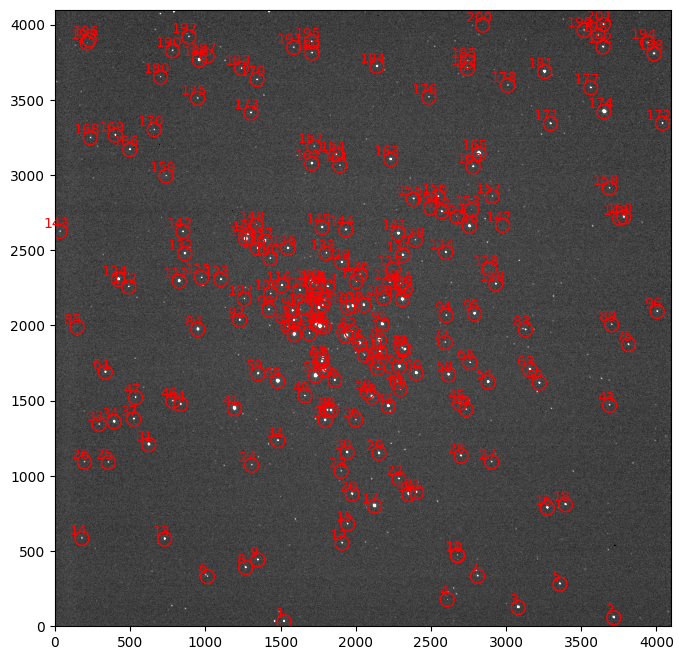

In [7]:
plt.figure(figsize = (8,8))
plt.imshow(corr_arr, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 100)
plt.scatter(peak_tab['x_peak'], peak_tab['y_peak'], s=100, edgecolors='r', facecolors='none')
for i in range (len(peak_tab)):
    plt.text(peak_tab['x_peak'][i]-25, peak_tab['y_peak'][i]+25, str(i+1), color = 'red', horizontalalignment = 'center')

If things get confusing and crowded, we can zoom in a bit

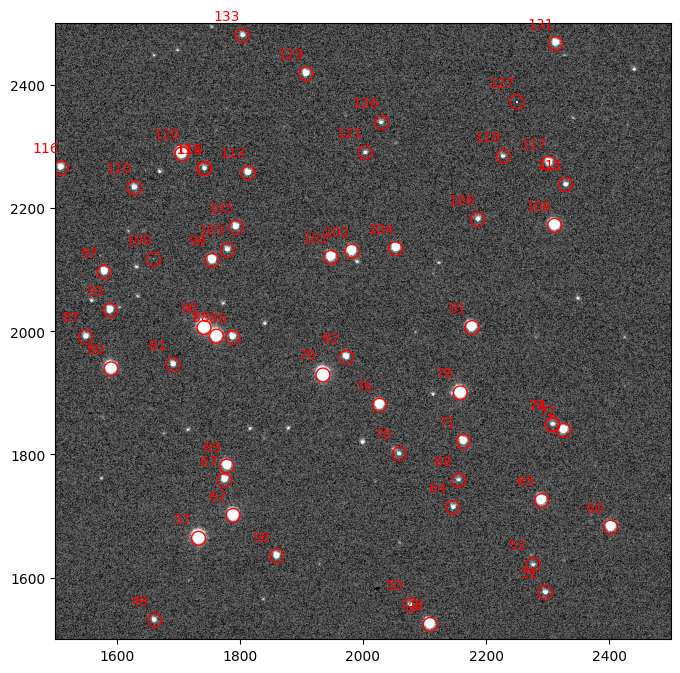

In [8]:
plt.figure(figsize = (8,8))
plt.imshow(corr_arr, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 100)
plt.scatter(peak_tab['x_peak'], peak_tab['y_peak'], s=100, edgecolors='r', facecolors='none')

x_lims = [1500, 2500]
y_lims = [1500, 2500]

plt.xlim(x_lims[0],x_lims[1])
plt.ylim(y_lims[0],y_lims[1])
for i in range (len(peak_tab)):
    if peak_tab['x_peak'][i] > x_lims[0] and peak_tab['x_peak'][i] < x_lims[1] and \
        peak_tab['y_peak'][i] > y_lims[0] and peak_tab['y_peak'][i] < y_lims[1]:
        plt.text(peak_tab['x_peak'][i]-25, peak_tab['y_peak'][i]+25, str(i+1), color = 'red', horizontalalignment = 'center')

In [9]:
# Define a function to cut out the stars one by one

def get_cutout(i, corr_arr):
    
    position = (peak_tab['x_peak'][i], peak_tab['y_peak'][i])  # Where the cutout should be centered
    size = (60, 60)     # The size of the cutout in pixels
    star1 = Cutout2D(corr_arr, position, size)
    
    return star1

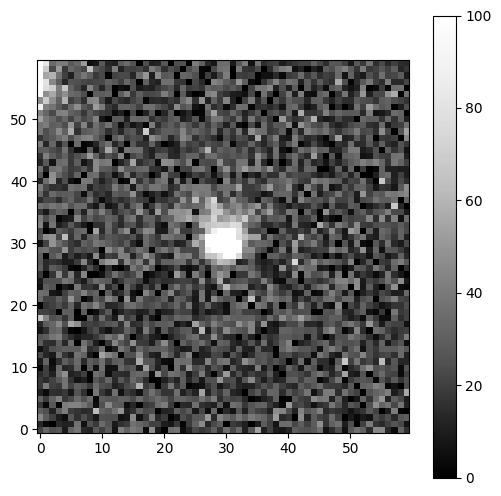

In [10]:
i = 114
star1 = get_cutout(i, corr_arr)

plt.figure(figsize = (6,6))
plt.imshow(star1.data, origin='lower', cmap = 'Greys_r', vmin = 0, vmax = 100)
plt.colorbar()

Imagine this figure as a bottom of a bucket; each pixel defines a position while the color tells us how many photons were dropped onto that position. A 3d plot grasps this aspect better:

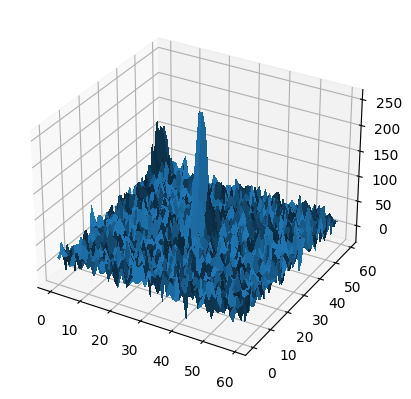

In [11]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xx = np.linspace(0, star1.data.shape[0] - 1, star1.data.shape[0])
X, Y = np.meshgrid(xx, xx)
ax.plot_surface(X, Y, star1.data, linewidth=1, antialiased=False)

What we essentially want to do, is to caluclate how many counts were acquired in the region where the star is, then compare it with other stars. However, this is a tricky step, since we need to find a region on the cutout, which contains _only_ the star we want to estimate the brightness for. If there are no other stars on the cutout, this step is simple. However, given that we are working with clusters, stars can get very close to each other; in that case, a smaller aperture has to be used for the calculation. On the other hand, brighter stars take up more space on the figure, hence in their case, a wider aperture has to chosen. To balance these two effects, the aperture radius has to be chosen dynamically, which can be done easily based on the full width at half maximum (FWHM) of the intensity profile.

In [12]:
def get_aperture_size(star1):
    star_tab = find_peaks(star1.data, bkg.background_rms_median * 10, box_size = 8)

    # First, get a list of stars on the cutout, and tell how far they are from the center
    size = (60, 60)
    dists_from_mid = np.sqrt(np.square(star_tab['x_peak'] - size[0]/2) + np.square(star_tab['y_peak'] - size[1]/2))

    star_tab = star_tab[dists_from_mid > 3]
    dists_from_mid = dists_from_mid[dists_from_mid > 3]

    # Unless there is only one star on the cutout, try to find the closest neightbour
    if len(dists_from_mid) > 1:
        mindist = np.min(dists_from_mid)

        neighbour_ind = list(dists_from_mid).index(mindist)

        # Get the peak intensity of the neighbour star and the one we try to estimate the brightness for
        neighbour_max_count = star1.data.T[star_tab['x_peak'][neighbour_ind],star_tab['y_peak'][neighbour_ind]]
        star_max_count = star1.data[int(size[0]/2),int(size[1]/2)]

        # Estimate the weighted midpoint between the two stars: this is the limiting point, which sets how far our aperture can
        # extend. Furhter away it is likely, that the majority of the flux comes from the neighbour star, which could contaminate
        # our measurement.
        mid_p = star_max_count / (neighbour_max_count + star_max_count) * (mindist - 4) + 2
        # Here, we apply the scaling with the peak fluxes, so that the midpoint will be closer to our star, in case it is fainter
        # than the neighbour (and it takes up less area). We set the minimal midpoint distance to 2; this area still likely belongs
        # to the star we want to observe, if it was found by the peak finder algorithm.

    else:
        # If there are no neighbour stars, then we can set this maximal distance manually. It is unlikely that a star covers
        # more than 11 pixels; in such case, it is likely that it is saturated already.
        mid_p = 11

    # The position of the measured star on the cutout; it should always be in the center.
    pos = (size[0]/2, size[1]/2)

    apss = []

    # To measure the best size for the aperture, one has to calculate the FWHM. This can be done through analytic fitting of a 
    # profile to the intensity distribution, or by an astropy routine. The second however requires the photometry to be carried out
    # first; hence, we carry out the aperture photometry chosing different sizes, then evaluate the results. Once done, we simply 
    # choose the best one, i.e. the smallest, that already contains most of the star, since that is the least biased.

    up_lim = 10
    if mid_p < 10:
        up_lim = mid_p
        # Set the limit for the iterative caluclation below. We don't want to go beyond the midpoint as explained above. 

    for i in range (int(up_lim)):
        # Set up a circular aperture at a given position with a given radius
        obj_aperture = CircularAperture(pos, r=i+1)
        # Carry out the photometry; the resulting table will contain the sum of the counts
        obj_table = aperture_photometry(star1.data, obj_aperture) 
        # The larger the aperture, the larger the counts, due to the non-zero background. If this is not true, then there are some
        # reduction problems in that region background, which we don't want to include.
        if i > 0 and obj_table['aperture_sum'] < apss[i-1]:
            break
        apss.append(obj_table['aperture_sum'])

    aperstats = ApertureStats(star1.data, obj_aperture) 
    # Calculate the FWHM based on the largest possible aperture
    best = aperstats.fwhm.value * 1.25
    
    return best, aperstats

best, aperstats =  get_aperture_size(star1)

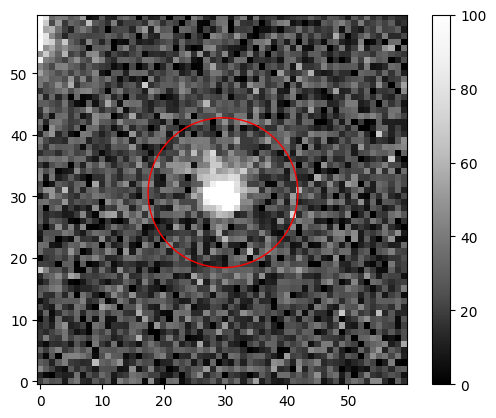

In [13]:
# We can check if the aperture size was chosen correctly; the red circle shows the area that will be considered during the
# photometry.

fig, ax = plt.subplots()
plt.imshow(star1.data, origin='lower', cmap = 'Greys_r', vmin = 0, vmax = 100)

circle1 = plt.Circle((aperstats.centroid[0], aperstats.centroid[1]), best, color = 'None', ec = 'red')

ax.add_patch(circle1)
plt.colorbar()

In [14]:
# Then finally obtain the total count for our chosen star

obj_aperture = CircularAperture(aperstats.centroid, r=best)
obj_table = aperture_photometry(star1.data, obj_aperture)
obj_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,29.638525101340818,30.599080137199877,16440.270666069362


### Let's do this procedure for all the stars

The script below runs the above task to all the stars, and in turn, we get a list of counts for each of the stars in the figure

In [15]:
import warnings
warnings.filterwarnings("ignore")

# The DataFrame with the final results. This will be filled iteratively
df = pd.DataFrame()

for i in range (len(peak_tab)):
    star1 = get_cutout(i, corr_arr)
    best, aperstats =  get_aperture_size(star1)
    
    obj_aperture = CircularAperture(aperstats.centroid, r=best)
    obj_table = aperture_photometry(star1.data, obj_aperture)
    
    temp = pd.Series([i+1, peak_tab['x_peak'][i], peak_tab['y_peak'][i], obj_table['aperture_sum'][0]],
                     ['Star_ID', 'X_c', 'Y_c', 'Count'])
    
    df = df.append(temp, ignore_index = True)

Now, we have the intensity counts for all the stars in the frame. What we need to do now, is to convert this to magnitudes, which we can interpret. For this, we have to find a star in the figure, for which we know the exact brightness value. 

This step can be done through multiple webpages. The one we recommend using is the aladin website: https://aladin.u-strasbg.fr/AladinLite/ Here, one can compare the observed frame to various catalogue, then can identify stars and check their magnitudes.

In [16]:
# Based on this one we can tell that the star with the index of 55 has a V band magnitude of 9.09, and a B band magnitude of 9.1
# We  can pick multiple reference stars from the frame, just make sure that their indices and magnitudes don't get confused. 
# And also make sure ot to pick a variable star as reference too.

# We can asssume that the B (blue) observations correspond to the Bessell B filter obsservations, while G (green) is also
# relatively close to Bessell V

ID_ref = [41, 55, 78]

ind_ref = np.array([list(df['Star_ID']).index(ID_ref[i]) for i in range (len(ID_ref))])

mag_ref_B = np.array([9.140, 9.1, 9.430])
mag_ref_V = np.array([9.140, 9.09, 9.360])

mags = np.zeros((len(df)))

for i in range (len(df)):
    mags[i] = np.average([-2.5 * np.log10(df['Count'][i]/df['Count'][ind_ref[j]]) + mag_ref_B[j] for j in range (len(ind_ref))])

df['Mag'] = mags 

In [17]:
df

,Star_ID,X_c,Y_c,Count,Mag
0,1.0,1523.0,31.0,23782.353820,12.047483
1,2.0,3716.0,56.0,42630.726795,11.413813
2,3.0,3081.0,124.0,63898.626149,10.974391
3,4.0,2609.0,176.0,12689.545820,12.729505
4,5.0,3358.0,280.0,21764.167645,12.143765
...,...,...,...,...,...
196,197.0,890.0,3919.0,14165.845948,12.610014
197,198.0,3612.0,3929.0,15089.358952,12.541443
198,199.0,3518.0,3962.0,13498.433454,12.662412
199,200.0,2844.0,3997.0,11872.635417,12.801752


### This was the basic outline of the procedure. To obtain a CMD, one has to carry this out for both the B and the V band images too. This is done by the script below; only the filenames have to be modified to get the correct result.

In [18]:
# Assume that the frames are well aligned; i.e. there is no need for rotational corrections and such, so we can use the same
# peak_tab as before

# B band observation filt_ind = 0

B_o_arr = fits.open(observation_files[0])[0].data.astype(float)
G_o_arr = fits.open(observation_files[1])[0].data.astype(float)
R_o_arr = fits.open(observation_files[2])[0].data.astype(float)


# -------------------------------------------
B_corr_arr = B_o_arr - d_arr
fail_cnd = B_corr_arr < -1000
B_corr_arr[fail_cnd] = 0

G_corr_arr = G_o_arr - d_arr
fail_cnd = G_corr_arr < -1000
G_corr_arr[fail_cnd] = 0

R_corr_arr = R_o_arr - d_arr
fail_cnd = R_corr_arr < -1000
R_corr_arr[fail_cnd] = 0
# Hopefully I will not need this part

# -------------------------------------------

# List of frames in different bands; they should be in the order of B G R for this script to work properly
corr_arr_s = [B_corr_arr, G_corr_arr, R_corr_arr]
bandlist = ['B', 'G', 'R']

df = pd.DataFrame()

for i in range (len(peak_tab)):        # Goes through all the detected stars
    
    count_vls = []
    added_bands = []
    
    try:
        for j in range (len(corr_arr_s)):  # Goes through the different bands

            star1 = get_cutout(i, corr_arr_s[j])
            best, aperstats =  get_aperture_size(star1)

            obj_aperture = CircularAperture(aperstats.centroid, r=best)
            obj_table = aperture_photometry(star1.data, obj_aperture)

            count_vls.append(obj_table['aperture_sum'][0])
            added_bands.append(bandlist[j] + '_count')
            
    except TypeError:
        continue     # It sometimes happens that there are no intensity peaks in the cutouts taken in bands that are different
                     # from the one we used to calculate the peak_tab. This can happen when the original peak was due to an
                     # artifact; hot pixels and such. Better leave these out.
    
    row = [i+1, peak_tab['x_peak'][i], peak_tab['y_peak'][i]]
    row.extend(count_vls)
    
    colnames = ['Star_ID', 'X_c', 'Y_c']
    colnames.extend(added_bands)
    
    temp = pd.Series(row, colnames)
    
    df = df.append(temp, ignore_index = True)

In [19]:
df

,Star_ID,X_c,Y_c,B_count,G_count,R_count
0,1.0,1523.0,31.0,23782.353820,30673.460648,35494.716999
1,2.0,3716.0,56.0,42630.726795,46199.338097,45006.493229
2,3.0,3081.0,124.0,63898.626149,70098.209702,66970.864860
3,4.0,2609.0,176.0,12689.545820,14676.021531,15679.508392
4,5.0,3358.0,280.0,21764.167645,24668.230940,23991.585913
...,...,...,...,...,...,...
188,195.0,1706.0,3887.0,15101.967539,18504.930674,18822.339275
189,197.0,890.0,3919.0,14165.845948,16838.936219,17699.724619
190,198.0,3612.0,3929.0,15089.358952,17013.945625,18345.779556
191,199.0,3518.0,3962.0,13498.433454,18042.169411,22791.066571


In [20]:
ID_ref = [41, 55, 78]

ind_ref = np.array([list(df['Star_ID']).index(ID_ref[i]) for i in range (len(ID_ref))])

mag_ref_B = np.array([9.140, 9.1, 9.430])
mag_ref_V = np.array([9.140, 9.09, 9.360])
mag_ref_R = np.array([9.000, 9.05, 9.30])

B_mags = np.zeros((len(df)))
G_mags = np.zeros((len(df)))
R_mags = np.zeros((len(df)))

for i in range (len(df)):
    B_mags[i] = np.average([-2.5 * np.log10(df['B_count'][i]/df['B_count'][ind_ref[j]]) + mag_ref_B[j] \
                            for j in range (len(ind_ref))])
    G_mags[i] = np.average([-2.5 * np.log10(df['G_count'][i]/df['G_count'][ind_ref[j]]) + mag_ref_V[j] \
                            for j in range (len(ind_ref))])
    R_mags[i] = np.average([-2.5 * np.log10(df['R_count'][i]/df['R_count'][ind_ref[j]]) + mag_ref_R[j] \
                            for j in range (len(ind_ref))])

df['B'] = B_mags 
df['G'] = G_mags 
df['R'] = R_mags 

The final dataframe, that includes the magnitude values as well

In [21]:
df

,Star_ID,X_c,Y_c,B_count,G_count,R_count,B,G,R
0,1.0,1523.0,31.0,23782.353820,30673.460648,35494.716999,12.047483,11.701879,11.356151
1,2.0,3716.0,56.0,42630.726795,46199.338097,45006.493229,11.413813,11.257196,11.098372
2,3.0,3081.0,124.0,63898.626149,70098.209702,66970.864860,10.974391,10.804519,10.666845
3,4.0,2609.0,176.0,12689.545820,14676.021531,15679.508392,12.729505,12.502265,12.243229
4,5.0,3358.0,280.0,21764.167645,24668.230940,23991.585913,12.143765,11.938441,11.781413
...,...,...,...,...,...,...,...,...,...
188,195.0,1706.0,3887.0,15101.967539,18504.930674,18822.339275,12.540536,12.250567,12.044876
189,197.0,890.0,3919.0,14165.845948,16838.936219,17699.724619,12.610014,12.352999,12.111644
190,198.0,3612.0,3929.0,15089.358952,17013.945625,18345.779556,12.541443,12.341773,12.072720
191,199.0,3518.0,3962.0,13498.433454,18042.169411,22791.066571,12.662412,12.278064,11.837148


In [22]:
def plot_CMD(band1, band2, df, vmi = None, vma = None):
    if vmi == None:
        plt.scatter(df[band1] - df[band2], df[band2], s = 10, c = df[band1] - df[band2], cmap = 'coolwarm')
    else:
        plt.scatter(df[band1] - df[band2], df[band2], s = 10, c = df[band1] - df[band2], cmap = 'coolwarm',
                    vmin = vmi, vmax = vma)
    plt.gca().invert_yaxis()

    plt.xlabel(band1 + '$-$' + band2, fontsize = 12)
    plt.ylabel(band2, fontsize = 12)

Now we only need to plot the CMDs; the colours go on the x axis, while the magnitudes go on the y axis.

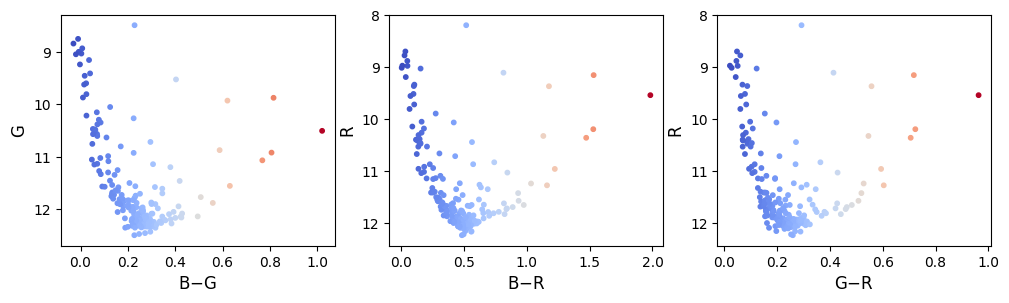

In [23]:
f = plt.figure(figsize = (12,3))

ax = f.add_subplot(1,3,1)
plot_CMD('B', 'G', df)

ax = f.add_subplot(1,3,2)
plot_CMD('B', 'R', df)

ax = f.add_subplot(1,3,3)
plot_CMD('G', 'R', df)

The main sequence is drawn out pretty nicely; however, there are a lot of outlier stars. Some of these are outliers due to not being part of the open cluster; given that we have applied the photometry on all the stars in the frame, we potentially include objects outside the cluster. To remove these, we can simply apply a constraint based on the position of the stars in the frame.

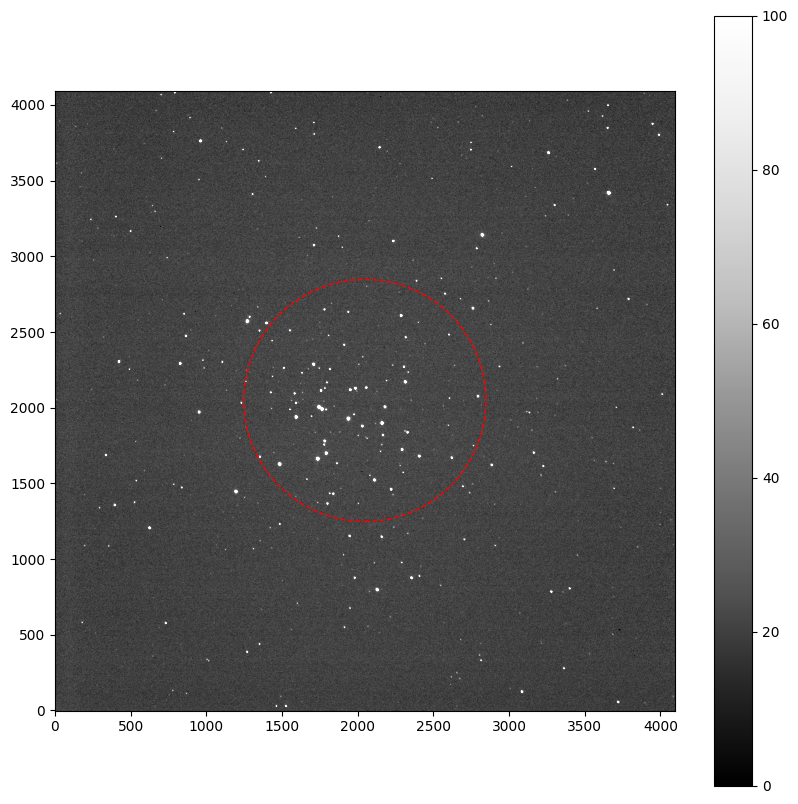

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(corr_arr, origin='lower', cmap = 'Greys_r',vmin = 0, vmax = 100)


center_of_frame = (int(corr_arr.shape[0]/2), int(corr_arr.shape[1]/2))  # This is the center, where the open cluster should be
radius = 800   # The observed radius of the open cluster, this has to be set manually

# We performed the photometry for the whole frame, but most likely some of the stars are not cluster members. The easiest way to
# remove these from the sample is to apply a constrain on the observed distance from the cluster; or to include only the stars
# that fall into the circle we draw.

circle1 = plt.Circle(center_of_frame, radius, color = 'None', ec = 'red', ls = '--')
ax.add_patch(circle1)
plt.colorbar()

In [25]:
# Condition to tell, whether the stars are in the circle plotted above or not
pos_cond = np.sqrt(np.square(df['X_c'] -  center_of_frame[0]) + np.square(df['Y_c'] -  center_of_frame[1])) < radius

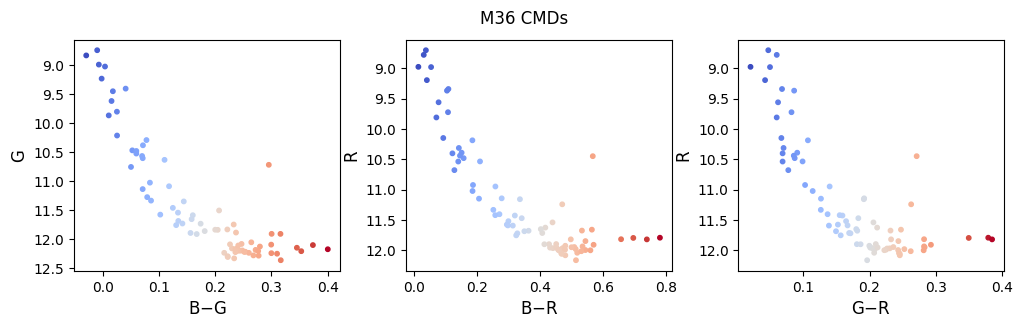

In [26]:
f = plt.figure(figsize = (12,3))
f.subplots_adjust(wspace = 0.25)

plt.suptitle('M36 CMDs', fontsize = 12)

ax = f.add_subplot(1,3,1)
plot_CMD('B', 'G', df[pos_cond])

ax = f.add_subplot(1,3,2)
plot_CMD('B', 'R', df[pos_cond])

ax = f.add_subplot(1,3,3)
plot_CMD('G', 'R', df[pos_cond])

And indeed, most of the outlier objects were succesfully removed, leaving us with the main sequence of the open cluster clearly visible.